## Pneumonia classification

In [1]:
!pip install sidetable -q

In [32]:
# import the needed dependencies
import os

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

import re
import glob
import pandas as pd
import sidetable

pd.options.mode.chained_assignment = None  # default='warn'

## EDA

- We use the names of the images to create a basic EDA to evaluate the context of the pictures

In [3]:
# read the global enviroment and create a dataframe that store the information
# this step is to analyze the information of the images

train_image_names = glob.glob('./chest_xray/train/*/*.jpeg')
print("Total number of training images: ", len(train_image_names))

# make train_image_names as serie object
train_image_names = pd.Series(train_image_names)


val_image_names = glob.glob('./chest_xray/val/*/*.jpeg')
print("Total number of validation images: ", len(val_image_names))

# make val_image_names as serie object
val_image_names = pd.Series(val_image_names)


test_image_names = glob.glob('./chest_xray/test/*/*.jpeg')
print("Total number of testing images: ", len(test_image_names))

# make val_image_names as serie object
test_image_names = pd.Series(test_image_names)

Total number of training images:  5216
Total number of validation images:  16
Total number of testing images:  624


The dataset from kaggle is already splitted in three folders, training images that containes 5216 images between normal and pneumonia images. The validation folder that contains 16 images between normal and pneumonia images, and testing images that contains 624 images. 

In [4]:
# train_df: a dataframe with 2 field: Filename, ClassId
train_df = pd.DataFrame()

# generate Filename field
train_df['Filename'] = train_image_names.map(lambda img_name: img_name.split("/")[-1])

# generate ClassId field
train_df['ClassId'] = train_image_names.map(lambda img_name: img_name.split("/")[-2])

train_df.head()

,Filename,ClassId
0,person276_bacteria_1296.jpeg,PNEUMONIA
1,person63_bacteria_306.jpeg,PNEUMONIA
2,person951_virus_1622.jpeg,PNEUMONIA
3,person780_bacteria_2684.jpeg,PNEUMONIA
4,person746_virus_1369.jpeg,PNEUMONIA


In [5]:
train_df_pneumonia = train_df[train_df['ClassId'] == "PNEUMONIA"]
train_df_pneumonia["type_pneumonia"] = train_df_pneumonia['Filename'].map(lambda img_name: img_name.split("_")[-2])

In [6]:
train_df_pneumonia[
    (
        train_df_pneumonia['type_pneumonia'] != "bacteria") 
    & (train_df_pneumonia['type_pneumonia'] != "virus" )
]

,Filename,ClassId,type_pneumonia
1651,person447_virus_921_1.jpeg,PNEUMONIA,921


One of the image is missclassified as 921 when it should be classify as virus. We find this image and change the label of the type of pneumonia

In [7]:
train_df_pneumonia.iloc[1651]['type_pneumonia'] = 'virus'

In [8]:
train_df.stb.freq(['ClassId'], style=True)

,ClassId,count,percent,cumulative_count,cumulative_percent
0,PNEUMONIA,"3,875",74.29%,"3,875",74.29%
1,NORMAL,"1,341",25.71%,"5,216",100.00%


The table shows that we have more data in the training data for pneumonia than normal x-ray. Our data is splitted by 74.29% of our observations is from pneumonia and 25.71% of our observations is Normal X-ray

In [9]:
train_df_pneumonia.stb.freq(['type_pneumonia'], style=True)

,type_pneumonia,count,percent,cumulative_count,cumulative_percent
0,bacteria,"2,530",65.29%,"2,530",65.29%
1,virus,"1,345",34.71%,"3,875",100.00%


From the x-ray classifed as pnuemonia we have 65.29% of the observations are from bacterial infection while 34.71% of the observations are from viral infection.

## Evaluate some examples

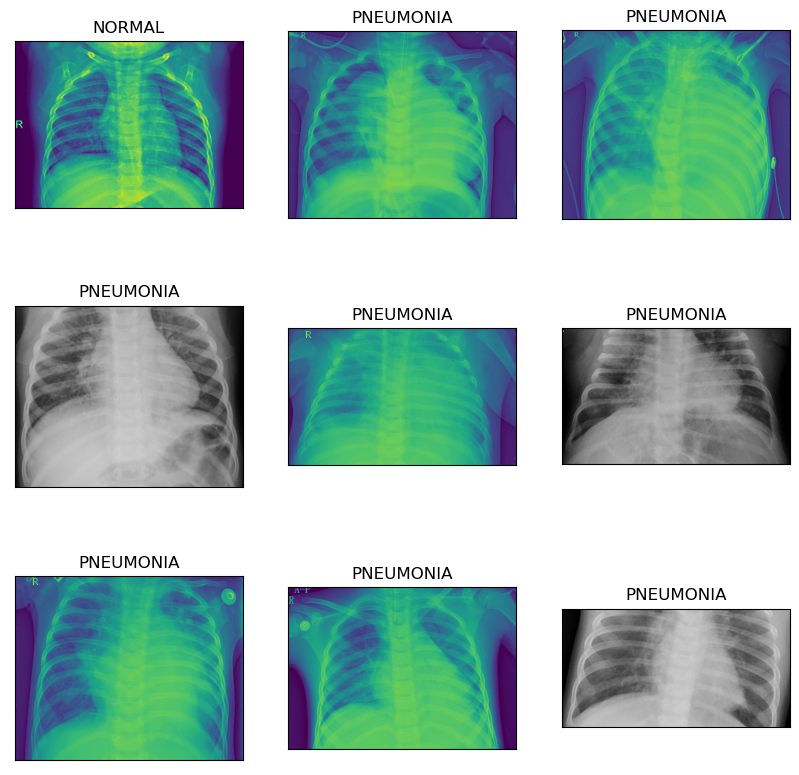

In [10]:
plot_df = train_df.sample(9).reset_index()
plt.figure(figsize=(10, 10))

for i in range(9):
    img_name = plot_df.loc[i, 'Filename']
    label_str = f"{plot_df.loc[i, 'ClassId']}"
    plt.subplot(3,3,i+1)
    plt.imshow(plt.imread(os.path.join('./chest_xray/train/',label_str, img_name)))
    plt.title(label_str)
    plt.xticks([])
    plt.yticks([])

We display some observation from the training data to have an idea on how it looks the different labels. 

Patient with Bacterial Pneumonia important things to have in mind:

- Epidemiology:
- Most common cause:
- X-ray common findings:

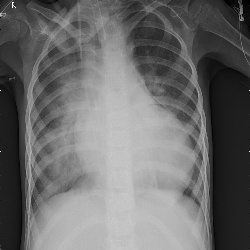

In [11]:
# patient with bacterial penumonia
path = './chest_xray/train/PNEUMONIA'
name = 'person1003_bacteria_2934.jpeg'
fullname = f'{path}/{name}'
load_img(fullname, target_size=(250, 250))

Patient with viral Pneumonia important things to have in mind:

- Epidemiology:
- Most common cause:
- X-ray common findings:

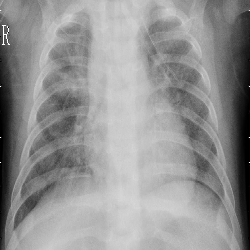

In [12]:
# patient with viral penumonia
path = './chest_xray/train/PNEUMONIA'
name = 'person1003_virus_1685.jpeg'
fullname = f'{path}/{name}'
load_img(fullname, target_size=(250, 250))

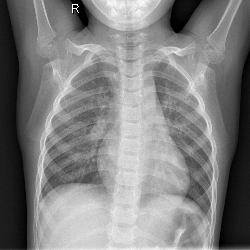

In [13]:
# patient without pneumonia
path = './chest_xray/train/NORMAL'
name = 'IM-0115-0001.jpeg'
fullname = f'{path}/{name}'
load_img(fullname, target_size=(250, 250))

In [14]:
img = load_img(fullname, target_size=(150, 150))
x = np.array(img)

X = np.array([x])
x.shape

(150, 150, 3)

In [15]:
train_dir = './chest_xray/train'
val_dir = './chest_xray/val'

In [16]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [25]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    shuffle=True)


Found 5216 images belonging to 2 classes.


In [18]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [26]:
validation_generator = val_datagen.flow_from_directory(val_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    shuffle=True)

Found 16 images belonging to 2 classes.


In [20]:
validation_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

# Tunning hyperparameters


## Evaluate for different learning rate

In [84]:
def make_model(learning_rate=0.001, size_inner=64, droprate=0.0):
    
    ####################################################
    
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu',
                            input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(droprate))
    model.add(layers.Dense(size_inner, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    ###################################################
    
    optimizer=keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.8)
    loss='binary_crossentropy'
    model.compile(loss=loss,
                 optimizer=optimizer,
                 metrics=['acc'])
    return model

In [92]:
scores = {}
for lr in [0.0001, 0.001, 0.01, 0.1]:
    model = make_model(learning_rate=lr, size_inner=64,droprate=0.0)
    print(lr)
    history = model.fit(train_generator, epochs=10, validation_data=validation_generator)
    scores[lr] = history.history
    print()
    print()


0.0001
Epoch 1/10
163/163 [==============================] - 50s 305ms/step - loss: 0.5009 - acc: 0.7536 - val_loss: 0.6920 - val_acc: 0.5625
Epoch 2/10
163/163 [==============================] - 50s 305ms/step - loss: 0.3902 - acc: 0.8271 - val_loss: 0.7540 - val_acc: 0.5625
Epoch 3/10
163/163 [==============================] - 50s 306ms/step - loss: 0.3206 - acc: 0.8859 - val_loss: 0.6125 - val_acc: 0.6875
Epoch 4/10
163/163 [==============================] - 50s 305ms/step - loss: 0.2732 - acc: 0.9087 - val_loss: 0.6023 - val_acc: 0.6875
Epoch 5/10
163/163 [==============================] - 50s 306ms/step - loss: 0.2418 - acc: 0.9181 - val_loss: 0.5486 - val_acc: 0.7500
Epoch 6/10
163/163 [==============================] - 50s 306ms/step - loss: 0.2185 - acc: 0.9270 - val_loss: 0.5362 - val_acc: 0.7500
Epoch 7/10
163/163 [==============================] - 50s 304ms/step - loss: 0.2015 - acc: 0.9302 - val_loss: 0.4487 - val_acc: 0.8125
Epoch 8/10
163/163 [============================

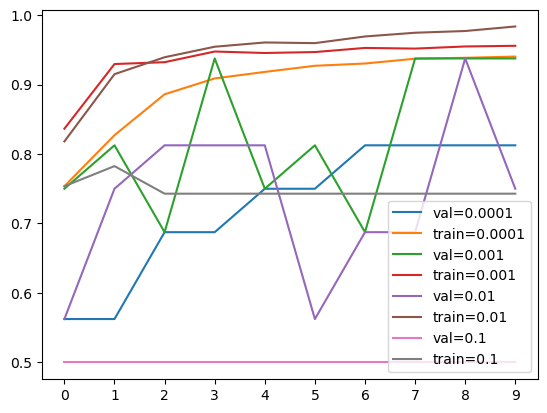

In [98]:
for lr, hist in scores.items():
    plt.plot(hist['val_acc'], label=('val=%s' %lr))
    plt.plot(hist['acc'], label=('train=%s' %lr))
plt.xticks(np.arange(10))
plt.legend()

The results suggest that the best learning rate is **0.001**

## Evaluate the size of the inner layer

In [28]:
scores = {}
learning_rate = 0.001

for size in [10, 100, 100]:
    print(size)
    model = make_model(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=0.0
    )
    
    print(size)
    history = model.fit(train_generator, epochs=10, validation_data=validation_generator)
    scores[size] = history.history
    print()
    print()

10
10
Epoch 1/10


2022-12-11 22:55:46.225239: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-12-11 22:55:46.867724: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-11 22:55:46.868635: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-11 22:55:46.868675: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-11 22:55:46.869708: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-11 22:55:46.869801: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


163/163 [==============================] - 58s 340ms/step - loss: 0.3864 - acc: 0.8252 - val_loss: 0.7377 - val_acc: 0.6250
Epoch 2/10
163/163 [==============================] - 50s 307ms/step - loss: 0.1996 - acc: 0.9248 - val_loss: 0.3479 - val_acc: 0.8125
Epoch 3/10
163/163 [==============================] - 49s 301ms/step - loss: 0.1667 - acc: 0.9362 - val_loss: 0.5268 - val_acc: 0.8125
Epoch 4/10
163/163 [==============================] - 49s 302ms/step - loss: 0.1541 - acc: 0.9402 - val_loss: 0.2458 - val_acc: 0.9375
Epoch 5/10
163/163 [==============================] - 49s 303ms/step - loss: 0.1347 - acc: 0.9479 - val_loss: 0.2068 - val_acc: 0.9375
Epoch 6/10
163/163 [==============================] - 50s 303ms/step - loss: 0.1249 - acc: 0.9517 - val_loss: 0.3772 - val_acc: 0.8125
Epoch 7/10
163/163 [==============================] - 49s 303ms/step - loss: 0.1312 - acc: 0.9519 - val_loss: 0.5468 - val_acc: 0.7500
Epoch 8/10
163/163 [==============================] - 50s 304ms/st

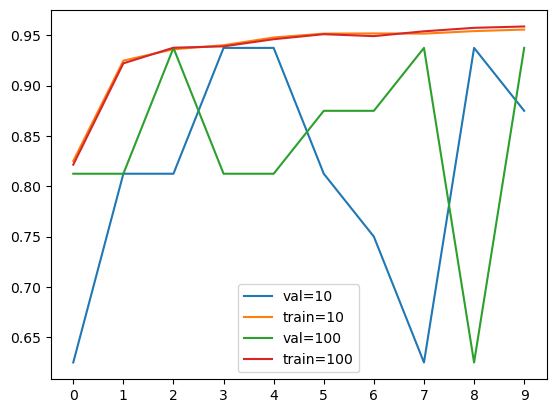

In [29]:
for size, hist in scores.items():
    plt.plot(hist['val_acc'], label=('val=%s' %size))
    plt.plot(hist['acc'], label=('train=%s' %size))
plt.xticks(np.arange(10))
plt.legend()

The best size of the inner layer is 100

In [30]:
learning_rate = 0.001
size = 100

In [31]:
scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)
    model = make_model(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
    )
    
    print(droprate)
    history = model.fit(train_generator, epochs=30, validation_data=validation_generator)
    scores[droprate] = history.history
    print()
    print()

0.0
0.0
Epoch 1/30
163/163 [==============================] - 50s 305ms/step - loss: 0.3343 - acc: 0.8629 - val_loss: 0.5504 - val_acc: 0.7500
Epoch 2/30
163/163 [==============================] - 49s 300ms/step - loss: 0.1744 - acc: 0.9335 - val_loss: 0.4801 - val_acc: 0.7500
Epoch 3/30
163/163 [==============================] - 49s 303ms/step - loss: 0.1514 - acc: 0.9413 - val_loss: 0.8550 - val_acc: 0.5625
Epoch 4/30
163/163 [==============================] - 49s 303ms/step - loss: 0.1562 - acc: 0.9365 - val_loss: 0.3515 - val_acc: 0.8125
Epoch 5/30
163/163 [==============================] - 49s 301ms/step - loss: 0.1276 - acc: 0.9513 - val_loss: 0.3741 - val_acc: 0.8125
Epoch 6/30
163/163 [==============================] - 50s 304ms/step - loss: 0.1269 - acc: 0.9525 - val_loss: 0.1845 - val_acc: 0.9375
Epoch 7/30
163/163 [==============================] - 49s 301ms/step - loss: 0.1175 - acc: 0.9555 - val_loss: 0.1890 - val_acc: 0.9375
Epoch 8/30
163/163 [===========================

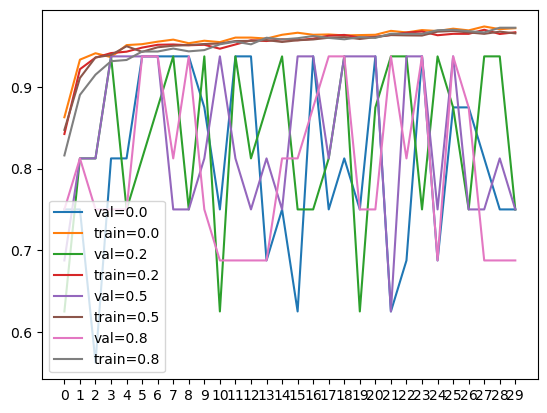

In [39]:
for droprate, hist in scores.items():
    plt.plot(hist['val_acc'], label=('val=%s' %droprate))
    plt.plot(hist['acc'], label=('train=%s' %droprate))
plt.xticks(np.arange(30))
plt.legend()

The best droprate is 0.8

In [ ]:
droprate = 0.8

In [33]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'pneumonia-class_v1_{epoch:02d}_{val_acc:.3f}.h5',
    save_best_only=True,
    monitor='val_acc',
    mode='max',
    
)

## Train the model

- Let's train the model with the best hyperparameters

In [34]:
learning_rate = 0.001
droprate = 0.8
size = 100

model = make_model(learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
    )
    
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

Epoch 1/10
163/163 [==============================] - 50s 305ms/step - loss: 0.4011 - acc: 0.8227 - val_loss: 0.7069 - val_acc: 0.6875
Epoch 2/10
163/163 [==============================] - 50s 305ms/step - loss: 0.2274 - acc: 0.9122 - val_loss: 0.2879 - val_acc: 0.9375
Epoch 3/10
163/163 [==============================] - 50s 304ms/step - loss: 0.1861 - acc: 0.9260 - val_loss: 0.4810 - val_acc: 0.7500
Epoch 4/10
163/163 [==============================] - 49s 303ms/step - loss: 0.1755 - acc: 0.9323 - val_loss: 0.3067 - val_acc: 0.8125
Epoch 5/10
163/163 [==============================] - 49s 301ms/step - loss: 0.1674 - acc: 0.9316 - val_loss: 0.2789 - val_acc: 0.8750
Epoch 6/10
163/163 [==============================] - 49s 302ms/step - loss: 0.1494 - acc: 0.9434 - val_loss: 0.6902 - val_acc: 0.6875
Epoch 7/10
163/163 [==============================] - 49s 303ms/step - loss: 0.1449 - acc: 0.9444 - val_loss: 0.5430 - val_acc: 0.7500
Epoch 8/10
163/163 [==============================] - 4

## Data augmentation

- Generate new images by using things that make sense for X-ray
- width shift
- height shift
- brightness
- zoom 

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

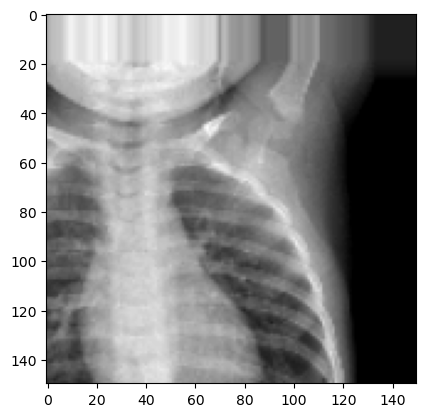

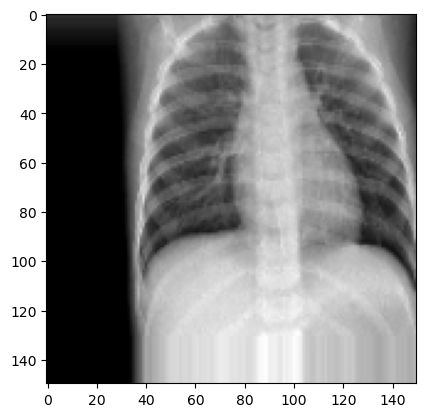

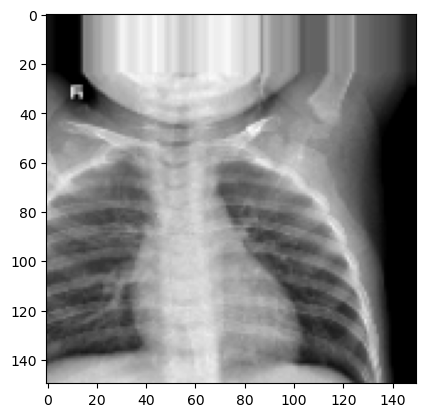

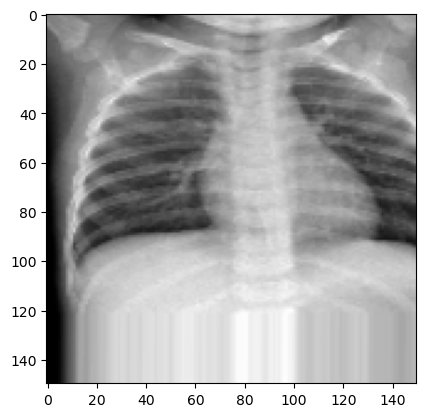

In [75]:
datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0, 1),
    shear_range=0.2,
    zoom_range=0.2,)

from tensorflow.keras.preprocessing import image
fnames = [os.path.join(train_dir+"/NORMAL", fname) for
    fname in os.listdir(train_dir+"/NORMAL")]

img_path = fnames[0]

img = image.load_img(img_path, target_size=(150, 150))

x = image.img_to_array(img)

x = x.reshape((1,) + x.shape)

i=0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

In [86]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0, 1),
    shear_range=0.2,
    zoom_range=0.2,)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    shuffle=True)

val_datagen = ImageDataGenerator(rescale=1./255)


validation_generator = val_datagen.flow_from_directory(val_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    shuffle=True)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [87]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'pneumonia-class_v5_{epoch:02d}_{val_acc:.3f}.h5',
    save_best_only=True,
    monitor='val_acc',
    mode='max'   
)

## Train the model with the data augmentation

In [88]:
learning_rate = 0.001
droprate = 0.8
size = 100

model = make_model(
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate)
    
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[checkpoint])


Epoch 1/50
163/163 [==============================] - 80s 491ms/step - loss: 0.6018 - acc: 0.7402 - val_loss: 0.7860 - val_acc: 0.5000
Epoch 2/50
163/163 [==============================] - 75s 462ms/step - loss: 0.5677 - acc: 0.7416 - val_loss: 0.8811 - val_acc: 0.5000
Epoch 3/50
163/163 [==============================] - 78s 478ms/step - loss: 0.5463 - acc: 0.7444 - val_loss: 0.7064 - val_acc: 0.5625
Epoch 4/50
163/163 [==============================] - 78s 479ms/step - loss: 0.5321 - acc: 0.7498 - val_loss: 0.6988 - val_acc: 0.6250
Epoch 5/50
163/163 [==============================] - 79s 482ms/step - loss: 0.5210 - acc: 0.7529 - val_loss: 0.6085 - val_acc: 0.7500
Epoch 6/50
163/163 [==============================] - 78s 480ms/step - loss: 0.5196 - acc: 0.7586 - val_loss: 0.6450 - val_acc: 0.5625
Epoch 7/50
163/163 [==============================] - 78s 479ms/step - loss: 0.5098 - acc: 0.7598 - val_loss: 0.6618 - val_acc: 0.6250
Epoch 8/50
163/163 [==============================] - 7

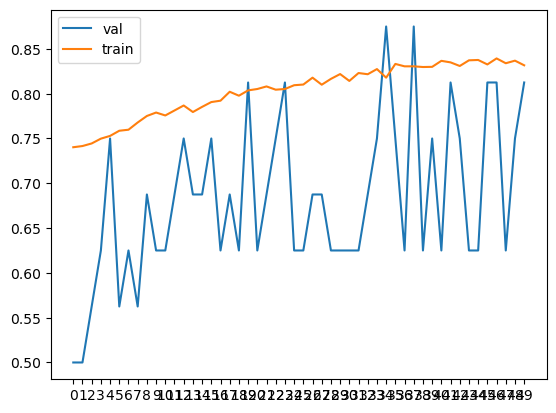

In [91]:
plt.plot(history.history['val_acc'], label=('val'))
plt.plot(history.history['acc'], label=('train'))
plt.xticks(np.arange(50))
plt.legend()

## Test a different architecture for the model

In [30]:
train_datagen_model2 = ImageDataGenerator(rescale=1./255)

val_datagen_model2 = ImageDataGenerator(rescale=1./255)

train_generator_2 = train_datagen_model2.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    shuffle=True)

validation_generator_2 = val_datagen_model2.flow_from_directory(val_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    shuffle=True)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [29]:
def make_model2(learning_rate=0.001, size_inner=64, droprate=0.0):
    
    ####################################################
    
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu',
                            input_shape=(150, 150, 3)))
    
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(droprate))
    model.add(layers.Dense(size_inner, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    ###################################################
    
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
    loss='binary_crossentropy'
    model.compile(loss=loss,
                 optimizer=optimizer,
                 metrics=['acc'])
    return model

In [33]:
scores = {}
for lr in [0.0001, 0.001, 0.01, 0.1]:
    model = make_model2(learning_rate=lr, size_inner=64,droprate=0.0)
    print(lr)
    history = model.fit(train_generator_2, epochs=10, validation_data=validation_generator_2)
    scores[lr] = history.history
    print()
    print()

0.0001
Epoch 1/10


2022-12-20 15:48:19.717132: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-12-20 15:48:21.768582: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-20 15:48:21.769509: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-20 15:48:21.769598: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-20 15:48:21.770763: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-20 15:48:21.770873: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


163/163 [==============================] - 65s 357ms/step - loss: 0.2691 - acc: 0.8871 - val_loss: 0.5604 - val_acc: 0.6875
Epoch 2/10
163/163 [==============================] - 54s 331ms/step - loss: 0.1071 - acc: 0.9584 - val_loss: 0.3285 - val_acc: 0.8750
Epoch 3/10
163/163 [==============================] - 53s 322ms/step - loss: 0.0870 - acc: 0.9672 - val_loss: 0.4605 - val_acc: 0.7500
Epoch 4/10
163/163 [==============================] - 52s 320ms/step - loss: 0.0782 - acc: 0.9709 - val_loss: 0.6259 - val_acc: 0.6875
Epoch 5/10
163/163 [==============================] - 52s 318ms/step - loss: 0.0603 - acc: 0.9791 - val_loss: 0.6099 - val_acc: 0.6875
Epoch 6/10
163/163 [==============================] - 52s 319ms/step - loss: 0.0555 - acc: 0.9804 - val_loss: 0.2881 - val_acc: 0.8750
Epoch 7/10
163/163 [==============================] - 52s 318ms/step - loss: 0.0500 - acc: 0.9820 - val_loss: 0.2528 - val_acc: 0.8750
Epoch 8/10
163/163 [==============================] - 52s 320ms/st

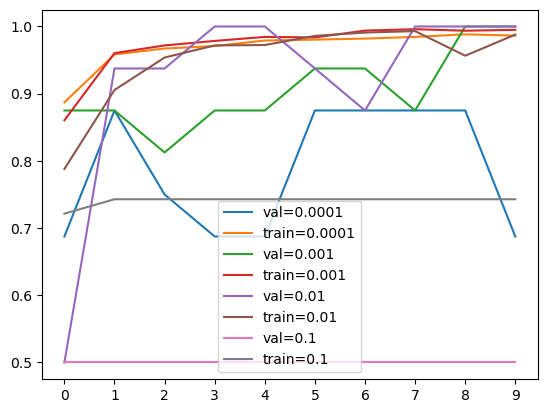

In [34]:
for lr, hist in scores.items():
    plt.plot(hist['val_acc'], label=('val=%s' %lr))
    plt.plot(hist['acc'], label=('train=%s' %lr))
plt.xticks(np.arange(10))
plt.legend()

In [35]:
scores = {}
learning_rate = 0.001

for size in [10, 64, 100]:
    print(size)
    model = make_model2(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=0.0
    )
    
    print(size)
    history = model.fit(train_generator_2, epochs=10, validation_data=validation_generator_2)
    scores[size] = history.history
    print()
    print()

10
10
Epoch 1/10
163/163 [==============================] - 53s 321ms/step - loss: 0.6757 - acc: 0.7387 - val_loss: 0.6954 - val_acc: 0.5000
Epoch 2/10
163/163 [==============================] - 52s 317ms/step - loss: 0.6487 - acc: 0.7429 - val_loss: 0.7026 - val_acc: 0.5000
Epoch 3/10
163/163 [==============================] - 52s 320ms/step - loss: 0.6253 - acc: 0.7429 - val_loss: 0.7130 - val_acc: 0.5000
Epoch 4/10
163/163 [==============================] - 52s 316ms/step - loss: 0.6082 - acc: 0.7429 - val_loss: 0.7256 - val_acc: 0.5000
Epoch 5/10
163/163 [==============================] - 52s 319ms/step - loss: 0.5958 - acc: 0.7429 - val_loss: 0.7386 - val_acc: 0.5000
Epoch 6/10
163/163 [==============================] - 52s 319ms/step - loss: 0.5871 - acc: 0.7429 - val_loss: 0.7522 - val_acc: 0.5000
Epoch 7/10
163/163 [==============================] - 52s 318ms/step - loss: 0.5811 - acc: 0.7429 - val_loss: 0.7645 - val_acc: 0.5000
Epoch 8/10
163/163 [=============================

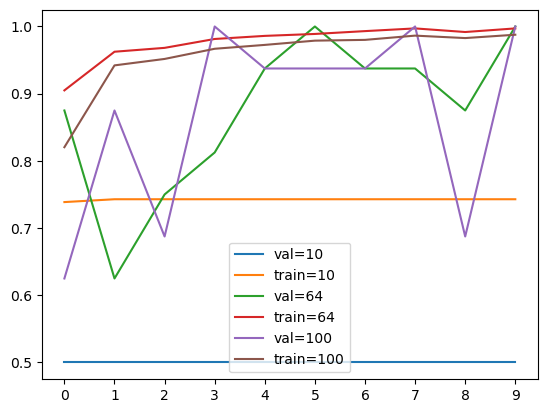

In [36]:
for size, hist in scores.items():
    plt.plot(hist['val_acc'], label=('val=%s' %size))
    plt.plot(hist['acc'], label=('train=%s' %size))
plt.xticks(np.arange(10))
plt.legend()

# Testing the model

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2022-12-13 00:27:38.986161: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
test_dir = './chest_xray/test'
model = keras.models.load_model('pneumonia-class_v1_03_0.938.h5')

2022-12-13 00:27:50.059880: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-13 00:27:50.075681: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-13 00:27:50.076374: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-13 00:27:50.077326: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [178]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    shuffle=True)

Found 624 images belonging to 2 classes.


In [179]:
model.evaluate(test_generator)

20/20 [==============================] - 5s 260ms/step - loss: 0.3575 - acc: 0.8301


[0.35749542713165283, 0.8301281929016113]

In [180]:
#path = 'githubusercontent.com/46135649/207101011-77379ccc-6684-4b74-93e4-852367e28920.png'
path = './chest_xray/test/PNEUMONIA'
name ='person100_bacteria_475.jpeg'
fullname = f'{path}/{name}'
img = load_img(fullname, target_size=(150, 150))

######################

path = './chest_xray/test/NORMAL'
name = 'IM-0003-0001.jpeg'
fullname = f'{path}/{name}'
img_2 = load_img(fullname, target_size=(150, 150))

In [181]:
import numpy as np

In [182]:
x = np.array(img)
x2 = np.array(img_2)
X = np.array([x, x2])
X.shape

(2, 150, 150, 3)

In [183]:
pred = model.predict(X)

1/1 [==============================] - 0s 51ms/step


In [184]:
pred

array([[1.0000000e+00],
       [1.3893104e-23]], dtype=float32)

In [185]:
np.where(pred > 0.6, 'Pneumonia', 'Normal')

array([['Pneumonia'],
       ['Normal']], dtype='<U9')

## Convert Keras to TF-Lite

In [3]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

with open('pneumonia-class.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpbxixnenc/assets


INFO:tensorflow:Assets written to: /tmp/tmpbxixnenc/assets
2022-12-13 00:28:00.626014: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-13 00:28:00.626071: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-12-13 00:28:00.627177: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpbxixnenc
2022-12-13 00:28:00.629157: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-12-13 00:28:00.629188: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /tmp/tmpbxixnenc
2022-12-13 00:28:00.634534: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-12-13 00:28:00.636124: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-12-13 00:28:00.722439: I tensorflow/cc/saved_model/loader.cc:212] Running initializatio

In [159]:
!ls -lh

total 3.6G
drwxrwsr-x 7 jovyan jovyan 4.0K Nov 20 14:53 chest_xray
-rw-rw-r-- 1 jovyan jovyan 2.3G Nov 20 14:45 chest-xray-pneumonia.zip
-rw-rw-r-- 1 jovyan jovyan 1.6M Dec 12 17:34 Notebook.ipynb
-rw-r--r-- 1 jovyan jovyan  67M Dec 12 17:35 pneumonia-class_tf_lite
-rw-rw-r-- 1 jovyan jovyan 134M Dec 12 02:19 pneumonia-class_v1_01_0.688.h5
-rw-rw-r-- 1 jovyan jovyan  86M Dec 10 14:17 pneumonia-class_v1_01_0.750.h5
-rw-rw-r-- 1 jovyan jovyan  67M Dec 12 17:34 pneumonia-class_v1_02_0.938.h5
-rw-rw-r-- 1 jovyan jovyan  86M Dec 10 14:19 pneumonia-class_v1_03_0.938.h5
-rw-r--r-- 1 jovyan jovyan 134M Dec 12 14:50 pneumonia-class_v5_01_0.500.h5
-rw-r--r-- 1 jovyan jovyan 134M Dec 12 14:52 pneumonia-class_v5_03_0.562.h5
-rw-r--r-- 1 jovyan jovyan 134M Dec 12 14:54 pneumonia-class_v5_04_0.625.h5
-rw-r--r-- 1 jovyan jovyan 134M Dec 12 14:55 pneumonia-class_v5_05_0.750.h5
-rw-r--r-- 1 jovyan jovyan 134M Dec 12 15:14 pneumonia-class_v5_20_0.812.h5
-rw-r--r-- 1 jovyan jovyan 134M Dec 12 15:34 pneum

## Use TensorFlow Lite

In [187]:
import tensorflow.lite as tflite

In [188]:
interpreter = tflite.Interpreter(model_path='pneumonia-class_tflite')
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

In [190]:
from io import BytesIO
from urllib import request

from PIL import Image

def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img


def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    return img

/tmp/ipykernel_161/2487457277.py:17: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  img = img.resize(target_size, Image.NEAREST)


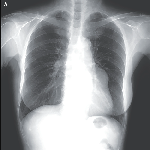

In [191]:
img = download_image('https://user-images.githubusercontent.com/46135649/207101011-77379ccc-6684-4b74-93e4-852367e28920.png')
img = prepare_image(img, target_size=(150, 150))
img

In [192]:
import numpy as np

def prepare_input(x):
    return x / 255.0

In [193]:
x = np.array(img, dtype='float32')
X = np.array([x])
X = prepare_input(X)

In [194]:
interpreter.set_tensor(input_index, X)
interpreter.invoke()

preds = interpreter.get_tensor(output_index)
preds

array([[0.8284671]], dtype=float32)